# Estimación de ICI mediante histogramas de diagramas de constelación

## Tareas
- [X] Hacerlo 2D
- [ ] Con ambos utilizar un clasificador
- [ ] En caso tal, variar los bins

## Librerías

In [1]:
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker
import json
import os

from scipy.io import loadmat
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.metrics import (accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from itertools import product
from time import time

2023-07-18 14:54:01.743929: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 14:54:01.745806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 14:54:01.778733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 14:54:01.779426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 14:54:02.406906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Funciones globales

In [2]:
# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

def plot_constellation_diagram(X, ax):
    ax.scatter(X.real, X.imag, alpha=0.5)
    ax.set_title("Constellation diagram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    
def calculate_gmm(data, gm_kwargs):
    return GaussianMixture(**gm_kwargs).fit(data)
    
def calculate_1d_histogram(X, bins):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]
    
    return hist_x, hist_y

def plot_1d_histogram(X, ax):
    ax.hist(X, bins=bins, density=True, alpha=0.5, label="Calculated histogram")
    
def plot_gmm_1d(gm, limits):
    x = np.linspace(*limits, 1000)
    
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    ax.plot(x, pdf_individual, '--', label="Adjusted histogram")

def plot_gmm_2d(gm, limits, ax):
    x = y = np.linspace(*limits)
    X, Y = np.meshgrid(x, y)
    Z = -gm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)

    ax.contour(
        X, Y, Z,
        norm=LogNorm(vmin=1.0, vmax=1000.0), 
        levels=np.logspace(0, 3, 25), cmap="seismic"
    )
    
def calculate_3d_histogram(X, bins, limits, spacing, snr):
    hist, xedges, yedges = np.histogram2d(X.real, X.imag, bins=bins, range=[[*limits], [*limits]])

    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    
    return hist, x_mesh, y_mesh
    
def plot_3d_histogram(x_mesh, y_mesh, hist, ax):
    ax.plot_surface(x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none")
    ax.set_title("3D Histogram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")

In [3]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(np.intersect1d(np.where(lower_limit < array), np.where(array <= upper_limit)))
    
    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull.replace(column_name, classfull)
    
    return df_classfull

def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        
        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n,
                               use_osnr=True, loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """
    # Set variable number
    var_n = 97 if use_osnr else 96
    
    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_cm(scores, interval_lst):
    CM = np.array(scores.get("cm").get("test"))
    for n, interval in enumerate(interval_lst):
        result = np.zeros(CM[0][0].shape)
        for cm in CM:
            result = np.add(result, cm[n])
        result /= np.sum(result)
        disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["Positive", "Negative"])
        disp.plot(colorbar=False)
        lower_limit, upper_limit = interval 
        plt.title(f"Confusion matrix for class from {lower_limit} GHz up to {upper_limit} GHz")
        plt.show()

In [12]:
def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()

## Restaurar variables

In [5]:
%store -r histograms_gmm
%store -r histograms_hist
%store -r scores_histograms_2classes_woOSNR
%store -r scores_histograms_2classes
%store -r scores_histograms_3classes_woOSNR
%store -r scores_histograms_3classes
%store -r scores_histograms_4classes_woOSNR
%store -r scores_histograms_4classes
%store -r scores_histograms_5classes_woOSNR
%store -r scores_histograms_5classes
%store -r scores_histograms_6classes_woOSNR
%store -r scores_histograms_6classes
%store -r scores_histograms_7classes_woOSNR
%store -r scores_histograms_7classes

no stored variable or alias scores_histograms_2classes_woOSNR
no stored variable or alias scores_histograms_2classes


## Leer datos

In [6]:
file_tx = "Demodulation/Data/2x16QAM_16GBd.mat"
folder_rx = "Demodulation/Data/"

# Transmitted data
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Read received data
data = read_data(folder_rx)

## Obtener histogramas

In [11]:
spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

histograms_hist = {}
histograms_gmm = {}
bins = 128
limits = [-5, 5]

for spacing in spacings:
    X_rx = data[f"{spacing}GHz_spacing"]
    for snr in X_rx:
        # Extract data 
        X_ch_norm = X_rx[snr].get("const_Y").flatten()
        X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm

        # Calculate 2D GMM
        input_data = np.vstack((X_ch.real, X_ch.imag)).T
        gm_kwargs = {
            "means_init": np.array(list(product([-3, -1, 1, 3], repeat=2))), 
            "n_components": 16
        }
        gm_2d = calculate_gmm(input_data, gm_kwargs)
        
        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, snr)
        
        # Save 3D histogram
        if histograms_hist.get(f"{spacing}GHz_spacing") == None:
            histograms_hist[f"{spacing}GHz_spacing"] = {}
        histograms_hist[f"{spacing}GHz_spacing"][snr[5:]] = hist
    
        # Calculate I and Q histograms
        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)

        # Q
        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
    
        # Save gaussians
        if histograms_gmm.get(f"{spacing}GHz_spacing") == None:
            histograms_gmm[f"{spacing}GHz_spacing"] = {}
        histograms_gmm[f"{spacing}GHz_spacing"][snr[5:]] = [gm_2d, gm_i, gm_q]
        
%store histograms_hist
%store histograms_gmm

Stored 'histograms_hist' (dict)
Stored 'histograms_gmm' (dict)


In [ ]:
spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

for spacing in spacings:
    X_rx = data[f"{spacing}GHz_spacing"]
    for snr in X_rx:
        # Extract data 
        X_ch_norm = X_rx[snr].get("const_Y").flatten()
        X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm

        plt.figure(figsize=(12, 12), layout="tight")

        # Plot constellation diagram
        ax = plt.subplot(2, 2, 1)
        plot_constellation_diagram(X_ch, ax)
        
        gm_2d = histograms_gmm.get(f"{spacing}GHz_spacing").get(f"{snr[5:]}")[0]
        
        # Plot 2D GMM
        plot_gmm_2d(gm_2d, limits, ax)
        ax.grid(True)

        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, snr)
        
        # Save 3D histogram
        if histograms_hist.get(f"{spacing}GHz_spacing") == None:
            histograms_hist[f"{spacing}GHz_spacing"] = {}
        histograms_hist[f"{spacing}GHz_spacing"][snr[5:]] = hist
    
        # Plot 3D histogram
        ax = plt.subplot(2, 2, 2, projection="3d")
        plot_3d_histogram(x_mesh, y_mesh, hist, ax)

        # Plot I and Q histograms separately
        # I
        ax = plt.subplot(2, 2, 3)
        plot_1d_histogram(X_ch.real, ax)
        
        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_i, limits)

        ax.set_title("I-Histogram")
        ax.set_xlabel("I")
        ax.grid(True)

        # Q
        ax = plt.subplot(2, 2, 4)
        plot_1d_histogram(X_ch.imag, ax)
        
        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_q, limits)
        ax.set_title("Q-Histogram")
        ax.set_xlabel("Q")
        ax.grid(True)
    
        # Save gaussians
        if histograms_gmm.get(f"{spacing}GHz_spacing") == None:
            histograms_gmm[f"{spacing}GHz_spacing"] = {}
        histograms_gmm[f"{spacing}GHz_spacing"][snr[5:]] = [gm_2d, gm_i, gm_q]

        plt.suptitle(f"Plots for {snr[5:]} OSNR and {spacing} GHz of spacing")

        plt.show()

## Preparar datos

In [7]:
# Dataframe con 98 columnas
# 16 primeras para las medias
# 64 siguientes para los valores de las matrices de covarianza
# Penúltima para el valor del OSNR (dB)
# Última para el valor del espaciamiento (GHz)

df_dict = {f"col{n}": [] for n in range(98)}

# Iterate over the dictionary and populate the DataFrame
for spacing, osnr in histograms_gmm.items():
    for osnr_, gmm_data in osnr.items():
        gmm = gmm_data[0]
        means = gmm.means_.flatten()
        covariances = gmm.covariances_.flatten()
        osnr_value = np.array([float(osnr_[:-2])])
        spacing_value = np.array([float(spacing[:-11])])
        
        features = np.concatenate((means, covariances, osnr_value, spacing_value))
        
        for n in range(98):
            df_dict[f"col{n}"].append(features[n])
# Reset the index of the DataFrame
df = pl.DataFrame(df_dict)

# Print the DataFrame
print(df)
df.write_json("histograms.json")

shape: (70, 98)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col94     ┆ col95    ┆ col96 ┆ col97 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -3.061319 ┆ -3.081539 ┆ -3.009816 ┆ -1.09713  ┆ … ┆ 0.003475  ┆ 0.267858 ┆ 35.0  ┆ 15.0  │
│ -2.791208 ┆ -2.838877 ┆ -2.852051 ┆ -0.881319 ┆ … ┆ -0.00648  ┆ 0.248093 ┆ 30.0  ┆ 15.0  │
│ -2.882368 ┆ -2.77302  ┆ -2.994856 ┆ -0.987074 ┆ … ┆ -0.004024 ┆ 0.295306 ┆ 25.0  ┆ 15.0  │
│ -2.945463 ┆ -2.961764 ┆ -2.916994 ┆ -1.104352 ┆ … ┆ 0.015604  ┆ 0.303943 ┆ 40.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -3.133734 ┆ -3.183742 ┆ -3.048293 ┆ -1.128834 ┆ … ┆ 

## Clasificador con 2 clases

In [32]:
interval_lst = [(0, 17.6), (17.6, 18)]
df_2classes = classificator(df, interval_lst, "col97")

In [33]:
%%time
args = {"data": df_2classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_2classes_woOSNR = calc_once("scores_histograms_2classes_woOSNR", test_classification_model, args)
%store scores_histograms_2classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 15ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 20ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_2classes_woOSNR' (dict)
CPU times: user 1min 25s, sys: 2.84 s, total: 1min 27s
Wall time: 1min 4s


In [34]:
%%time
args = {"data": df_2classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_2classes = calc_once("scores_histograms_2classes", test_classification_model, args)
%store scores_histograms_2classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Stored 'scores_histograms_2classes' (dict)
CPU times: user 1min 25s, sys: 2.95 s, total: 1min 27s
Wall time: 1min 5s


## Clasificador con 3 clases

In [35]:
interval_lst = [(0, 17), (17, 17.6), (17.6, 18)]
df_3classes = classificator(df, interval_lst, "col97")

In [50]:
%%time
args = {"data": df_3classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_3classes_woOSNR = calc_once("scores_histograms_3classes_woOSNR", test_classification_model, args)
%store scores_histograms_3classes_woOSNR

Stored 'scores_histograms_3classes_woOSNR' (dict)
CPU times: user 81.2 ms, sys: 9.07 ms, total: 90.3 ms
Wall time: 93 ms


In [51]:
%%time
args = {"data": df_3classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_3classes = calc_once("scores_histograms_3classes", test_classification_model, args)
%store scores_histograms_3classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_3classes' (dict)
CPU times: user 1min 22s, sys: 2.65 s, total: 1min 24s
Wall time: 1min 2s


## Clasificador con 4 clases

In [52]:
interval_lst = [(0, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_4classes = classificator(df, interval_lst, "col97")

In [53]:
%%time
args = {"data": df_4classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_4classes_woOSNR = calc_once("scores_histograms_4classes_woOSNR", test_classification_model, args)
%store scores_histograms_4classes_woOSNR

Stored 'scores_histograms_4classes_woOSNR' (dict)
CPU times: user 80.9 ms, sys: 9.1 ms, total: 90 ms
Wall time: 93.2 ms


In [54]:
%%time
args = {"data": df_4classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_4classes = calc_once("scores_histograms_4classes", test_classification_model, args)
%store scores_histograms_4classes

Stored 'scores_histograms_4classes' (dict)
CPU times: user 84.8 ms, sys: 8.04 ms, total: 92.9 ms
Wall time: 96.1 ms


## Clasificador con 5 clases

In [55]:
interval_lst = [(0, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_5classes = classificator(df, interval_lst, "col97")

In [56]:
%%time
args = {"data": df_5classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_5classes_woOSNR = calc_once("scores_histograms_5classes_woOSNR", test_classification_model, args)
%store scores_histograms_5classes_woOSNR

Stored 'scores_histograms_5classes_woOSNR' (dict)
CPU times: user 80.6 ms, sys: 10.1 ms, total: 90.7 ms
Wall time: 93.7 ms


In [57]:
%%time
args = {"data": df_5classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_5classes = calc_once("scores_histograms_5classes", test_classification_model, args)
%store scores_histograms_5classes

Stored 'scores_histograms_5classes' (dict)
CPU times: user 81.8 ms, sys: 12 ms, total: 93.7 ms
Wall time: 96.9 ms


## Clasificador con 6 clases

In [58]:
interval_lst = [(0, 15.5), (15.5, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_6classes = classificator(df, interval_lst, "col97")

In [59]:
%%time
args = {"data": df_6classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_6classes_woOSNR = calc_once("scores_histograms_6classes_woOSNR", test_classification_model, args)
%store scores_histograms_6classes_woOSNR

Stored 'scores_histograms_6classes_woOSNR' (dict)
CPU times: user 80.1 ms, sys: 11.1 ms, total: 91.2 ms
Wall time: 94 ms


In [60]:
%%time
args = {"data": df_6classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_6classes = calc_once("scores_histograms_6classes", test_classification_model, args)
%store scores_histograms_6classes

Stored 'scores_histograms_6classes' (dict)
CPU times: user 78.1 ms, sys: 10.1 ms, total: 88.2 ms
Wall time: 91.5 ms


## Clasificador con 7 clases

In [61]:
interval_lst = [(0, 15), (15, 15.5), (15.5, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_7classes = classificator(df, interval_lst, "col97")

In [62]:
%%time
args = {"data": df_7classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_7classes_woOSNR = calc_once("scores_histograms_7classes_woOSNR", test_classification_model, args)
%store scores_histograms_7classes_woOSNR

Stored 'scores_histograms_7classes_woOSNR' (dict)
CPU times: user 83.8 ms, sys: 8.07 ms, total: 91.9 ms
Wall time: 95.3 ms


In [63]:
%%time
args = {"data": df_7classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_7classes = calc_once("scores_histograms_7classes", test_classification_model, args)
%store scores_histograms_7classes

Stored 'scores_histograms_7classes' (dict)
CPU times: user 80.3 ms, sys: 10.1 ms, total: 90.4 ms
Wall time: 94 ms


## Gráficas

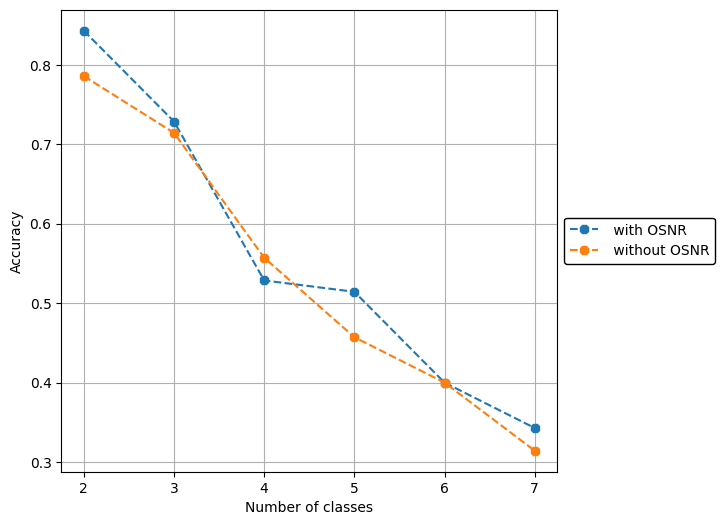

In [65]:
classes_n = [2, 3, 4, 5, 6, 7]
OSNR = ["", "_woOSNR"]
classes_scores = {f"scores_histograms{osnr}":
                  [np.average(
                      eval(f"scores_histograms_{n}classes{osnr}").get(
                          "acc"
                      ).get(
                          "test"
                      )
                  ) for n in classes_n]
                  for osnr in OSNR
                 }
plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for osnr in OSNR:
    OSNR_label = " with OSNR" if osnr == "" else " without OSNR"
    marker = "8"
    plt.plot(classes_n, classes_scores.get(f"scores_histograms{osnr}"),
             marker=marker, linestyle="--",
             label=OSNR_label)
plt.xlabel("Number of classes")
ax.set_xticks(classes_n)
plt.ylabel("Accuracy")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Transparent white box black edge legend
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                    edgecolor="black")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.01))
plt.grid(True)

plt.savefig("hist_classes.svg", format="svg", transparent=True, bbox_inches="tight")